<a href="https://colab.research.google.com/github/nabbawabba/pytorchexp/blob/main/ch_03/03_character_language_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Based Character Language Model
A language model looks at the context to generate next set of words or characters. This context is also called as a sliding window which moves across the input sentence from left to right(right to left for language which are written from right to left).

In this notebook we will :
- Build a character based language model from scratch.
- The model will be trained on the text from a book
- We will use different decoding strategies to generate text

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PacktPublishing/Generative-AI-with-Python-and-PyTorch-Second-Edition/blob/master/ch_03/03_character_language_model.ipynb)

### Import Required Libraries

In [1]:
import torch
import numpy as np
from tqdm.notebook import tqdm
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch.nn import Embedding, Linear, LSTM, Module, Dropout
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

### Get the Dataset :: Project Gutenberg
_From the Website_ :

>"Project Gutenberg is an online library of free eBooks.
Project Gutenberg was the first provider of free electronic books, or eBooks. Michael Hart, founder of Project Gutenberg, invented eBooks in 1971 and his memory continues to inspire the creation of eBooks and related content today."

We will be working with the famous book **Metamorphosis** by Franz Kafka to train our own language model

In [2]:
!wget -O metamorphosis_franz_kafka.txt https://gutenberg.org/ebooks/5200.txt.utf-8

--2025-07-10 21:35:25--  https://gutenberg.org/ebooks/5200.txt.utf-8
Resolving gutenberg.org (gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to gutenberg.org (gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://gutenberg.org/cache/epub/5200/pg5200.txt [following]
--2025-07-10 21:35:26--  http://gutenberg.org/cache/epub/5200/pg5200.txt
Connecting to gutenberg.org (gutenberg.org)|152.19.134.47|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://gutenberg.org/cache/epub/5200/pg5200.txt [following]
--2025-07-10 21:35:27--  https://gutenberg.org/cache/epub/5200/pg5200.txt
Connecting to gutenberg.org (gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 142054 (139K) [text/plain]
Saving to: ‘metamorphosis_franz_kafka.txt’

metamorphosis_franz 100%[===================>] 138.72K   211KB/s    in 0.7s    

2025-07-10 21:35

In [3]:
# Load the text file
datafile_path = r'./metamorphosis_franz_kafka.txt'
text = open(datafile_path, 'rb').read().decode(encoding='utf-8')
print ('Book contains a total of {} characters'.format(len(text)))

Book contains a total of 140527 characters


In [4]:
idx = 920
print(text[idx:idx+500])


Metamorphosis

by Franz Kafka

Translated by David Wyllie




I


One morning, when Gregor Samsa woke from troubled dreams, he found
himself transformed in his bed into a horrible vermin. He lay on his
armour-like back, and if he lifted his head a little he could see his
brown belly, slightly domed and divided by arches into stiff sections.
The bedding was hardly able to cover it and seemed ready to slide off
any moment. His many legs, pitifully thin compared with the size of t


### Check if GPU is Available
> Speeds up training like anything 🤫

In [5]:
CUDA = True if torch.cuda.is_available() else False
if CUDA:
  DEVICE = 'cuda'
  Tensor = torch.cuda.FloatTensor
  LongTensor = torch.cuda.LongTensor
else:
  DEVICE = 'cpu'
  Tensor = torch.FloatTensor
  LongTensor = torch.LongTensor
print(f"is GPU Available={CUDA}")

is GPU Available=True


### Time to Prepare the Dataset Class

This class helps with:
- Maintain character to integer and vice-versa lookups
- Copy of the original text
- Vocabulary, in this case unique characters in the book
- Window/Context size for the model to work with
- Utilities such as length and getitem to interface with ```pytorch```

In [6]:
class CharLMDataset(Dataset):
    def __init__(self, data, window_size=100):
        super(CharLMDataset, self).__init__()
        self.text = text
        self.window_size = window_size
        self.vocab = tuple(set(text))
        self.int2char = dict(enumerate(self.vocab))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}

    def __len__(self):
        return len(self.text) - self.window_size

    def __getitem__(self, ix):
        X = LongTensor(
            [self.char2int[c] for c in self.text[ix : ix + self.window_size]]
        )
        y = self.char2int[self.text[ix + self.window_size]]

        return X, y

### Time Contruct our Character Language Model using LSTMs

In [18]:
class CharLM(Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim=16,
        dense_dim=32,
        hidden_dim=8,
        n_layers=2,
    ):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.dense_dim = dense_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = Embedding(
                self.vocab_size,
                self.embedding_dim,
        )
        self.lstm = LSTM(
                self.embedding_dim,
                self.hidden_dim,
                batch_first=True,
                num_layers=self.n_layers
        )
        self.dropout = Dropout(p=0.4)
        self.linear_1 = Linear(self.hidden_dim, self.dense_dim)
        self.linear_2 = Linear(self.dense_dim, self.vocab_size)


    def forward(self, x, h=None, c=None):
        emb = self.embedding(x)
        if h is not None and c is not None:
            _, (h, c) = self.lstm(emb, (h, c))
        else:
            _, (h, c) = self.lstm(emb)

        h_mean = h.mean(dim=0)
        drop_out = self.dropout(h_mean)
        linear1_out = self.linear_1(drop_out)
        logits = self.linear_2(linear1_out)

        return logits, h, c

### Utility to Calculate Loss Across Batches

In [7]:
def compute_loss(criterion, model, dataloader):
    model.eval()
    total_loss = []
    for X_batch, y_batch in dataloader:
        if CUDA:
            X_batch = X_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
        probs, _, _ = model(X_batch)

        total_loss.append(criterion(probs, y_batch).item())

    return np.mean(total_loss)

### Utility to Generate Text Using out Model

In [8]:
def beam_search(n_chars,model,dataset,input_ints,topk=2):
  model.eval()

  # Initialize beams
  beam_scores = torch.zeros(topk).to(DEVICE)

  # Create a copy of the inital input
  beam_sequences = input_ints.clone()
  for step in range(n_chars):
    # Get next token using the model
    logits= model(beam_sequences)

    # transform output into probability
    logits = logits[0]
    probs = F.softmax(logits, dim=-1)

    # Get topk scores and corresponding indices
    top_scores, top_indices = torch.topk(probs.flatten(), k=topk, sorted=False)

    # Assign tokens to corresponding beams
    beam_indices = top_indices // probs.shape[-1]
    token_indices = top_indices % probs.shape[-1]
    beam_sequences = torch.cat([
        beam_sequences[beam_indices],
        token_indices.unsqueeze(-1)
    ], dim=-1)

    # maintaiin best scores
    beam_scores = top_scores

  # Fetch the beam with best score
  best_beam = beam_scores.argmax()
  best_sequence = beam_sequences[best_beam]

  # decode the best beam and return
  return ''.join([dataset.vocab[i] for i in best_sequence])

In [9]:
def generate_text(
    n_chars,
    model,
    dataset,
    prompt_text="Hello",
    mode="sampling",
    topk=2,
    temperature=1.0,
    random_state=42,
):
    AVAILABLE_MODES = ["greedy", "sampling", "topk_sampling", "beam_search"]
    resulting_string = prompt_text
    model.eval()
    h, c = None, None

    np.random.seed(random_state)
    next_char = None
    for _ in range(n_chars):
        if mode not in AVAILABLE_MODES:
            print(f"Incorrect decoding mode. Please use one of {AVAILABLE_MODES}")
            break
        if temperature <= 0.0:
            print(f"Use temperature values between (0,1] only")
            break

        # get model input
        input_chars = (
            resulting_string
            if resulting_string == prompt_text
            else resulting_string[-1]
        )
        input_ints = LongTensor([[dataset.char2int[c] for c in input_chars]])

        if mode == "beam_search":
            return beam_search(n_chars,model,dataset,input_ints,topk)
        else:
            # get model to generate next character
            logits, h, c = model(input_ints, h, c)

            # decode as per selected mode
            if mode == "greedy":
                next_char = dataset.vocab[torch.argmax(logits[0], dim=-1)]
            elif mode == "sampling":
                # transform into probabilities
                probs = F.softmax(logits[0], dim=0).detach().cpu().numpy()

                # get next char
                next_char = np.random.choice(dataset.vocab, p=probs)
            elif mode == "topk_sampling":
                # Get top k logits and corresponding indices
                top_k_logits, top_k_indices = torch.topk(logits[0], topk)

                # Apply softmax and temperature scaling
                top_k_probs = F.softmax(top_k_logits / temperature, dim=-1)

                # Get next topken index
                next_token_index = torch.multinomial(top_k_probs, num_samples=1)

                # Transform next token index to character
                next_token = top_k_indices.gather(-1, next_token_index)
                next_char = dataset.vocab[next_token]
            resulting_string += next_char

    return resulting_string

### Hyperparameters

In [10]:
# training hyper params
batch_size = 1024
n_epochs = 30

# model hyper params
n_layers = 2
dense_dim = 32
hidden_dim = 128
window_size = 100
embedding_dim = 64

### Instantiate the Objects

In [11]:
# Prepare Dataset Object
charlm_dataset = CharLMDataset(text[idx:], window_size=window_size)

# Get key attributes for model and training setup
n_samples = len(charlm_dataset)
vocab_size = len(charlm_dataset.vocab)
train_split_idx = int(n_samples * 0.8)

# split training and validation indices
train_indices, val_indices = np.arange(train_split_idx), np.arange(train_split_idx, n_samples)

In [12]:
# Prepare Dataloaders for Training and Validation
train_dataloader = DataLoader(
    charlm_dataset,
    sampler=SubsetRandomSampler(train_indices),
    batch_size=batch_size
    )
val_dataloader = DataLoader(
        charlm_dataset,
        sampler=SubsetRandomSampler(val_indices),
        batch_size=batch_size
)

In [19]:
# Initialize Model Object
char_lm = CharLM(
            vocab_size,
            hidden_dim=hidden_dim,
            n_layers=n_layers,
            dense_dim=dense_dim,
            embedding_dim=embedding_dim,
    )

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
            char_lm.parameters(),
            lr=1e-2,
    )

In [20]:
# Leverage GPU if available
if CUDA:
  char_lm.cuda()

### Let us Train our very 1st Language Model

In [21]:
# train the model
history_train_loss = list()
history_val_loss = list()
prompt_text = "“What’s happened to me?” he thought. It wasn’t a dream. His "
for e in range(n_epochs + 1):
        char_lm.train()
        train_loss = 0.0
        for X_batch, y_batch in tqdm(train_dataloader):
            if e ==0 :
              break
            optimizer.zero_grad()
            probs, _, _ = char_lm(X_batch.to('cuda'))
            train_loss = criterion(probs, y_batch.to('cuda'))
            train_loss.backward()

            optimizer.step()

        val_loss = compute_loss(criterion, char_lm, val_dataloader)
        print(f"Epoch: {e}, {train_loss=:.3f}, {val_loss=:.3f}")
        history_train_loss.append(train_loss)
        history_val_loss.append(val_loss)

        if e % 3 == 0:
          # Generate one sentence
          # sampling based generation
          generated_text = generate_text(
              100, char_lm, charlm_dataset, prompt_text=prompt_text
          )
          print(generated_text)

  0%|          | 0/110 [00:00<?, ?it/s]

/tmp/ipython-input-6-3615649873.py:14: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:78.)
  X = LongTensor(


Epoch: 0, train_loss=0.000, val_loss=4.523
ClMAP$b;““*
‘JqnJ?5sK3Sçq,C089*E2L# çB]7*3I“$4:pMci1ç—•jb?NInmXRQK.9AoQX?#Wh—C’—oawf#AvyQ 
‘6r


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 1, train_loss=1.918, val_loss=2.481


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 2, train_loss=1.716, val_loss=2.338


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 3, train_loss=1.675, val_loss=2.257
“What’s happened to me?” he thought. It wasn’t a dream. His apperire only Shat ho had father
course, is of the could room and by buistoor door
as earle bethin


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 4, train_loss=1.576, val_loss=2.198


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 5, train_loss=1.400, val_loss=2.182


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 6, train_loss=1.505, val_loss=2.136
“What’s happened to me?” he thought. It wasn’t a dream. His appening tieven
that he was rounded not, it was feelly nod!”, hom sict”. moving that stood of there


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 7, train_loss=1.414, val_loss=2.136


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 8, train_loss=1.453, val_loss=2.109


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 9, train_loss=1.402, val_loss=2.108
“What’s happened to me?” he thought. It wasn’t a dream. His head just impor had on the othernember than he still was
room and lice;
some keeting to get of thi


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 10, train_loss=1.388, val_loss=2.094


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 11, train_loss=1.366, val_loss=2.123


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 12, train_loss=1.320, val_loss=2.088
“What’s happened to me?” he thought. It wasn’t a dream. His head fist impution a did sutting
cerk and
hen the couch,
and he was night infertn us wanted to ru


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 13, train_loss=1.349, val_loss=2.123


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 14, train_loss=1.380, val_loss=2.107


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 15, train_loss=1.313, val_loss=2.102
“What’s happened to me?” he thought. It wasn’t a dream. His head”
looked his and, and that necesson, is mother plocking her times his mother and moven back and


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 16, train_loss=1.430, val_loss=2.102


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 17, train_loss=1.294, val_loss=2.092


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 18, train_loss=1.328, val_loss=2.116
“What’s happened to me?” he thought. It wasn’t a dream. His feesing as
end
the just day. Now she train that would no as make, need. And, despite the
eyes tim


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 19, train_loss=1.259, val_loss=2.130


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 20, train_loss=1.174, val_loss=2.136


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 21, train_loss=1.304, val_loss=2.147
“What’s happened to me?” he thought. It wasn’t a dream. His father
sonly from his how that nece “that
he street opening she dake him so, getting that became



  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 22, train_loss=1.247, val_loss=2.134


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 23, train_loss=1.283, val_loss=2.111


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 24, train_loss=1.309, val_loss=2.141
“What’s happened to me?” he thought. It wasn’t a dream. His sbook,
this hands a driven there per’s doing his compomition when she himself for in one down there


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 25, train_loss=1.218, val_loss=2.119


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 26, train_loss=1.289, val_loss=2.167


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 27, train_loss=1.180, val_loss=2.117
“What’s happened to me?” he thought. It wasn’t a dream. His seemen, of
but he had all this recently, it was flect with his head
builled
dembing to get some



  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 28, train_loss=1.313, val_loss=2.138


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 29, train_loss=1.195, val_loss=2.159


  0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 30, train_loss=1.287, val_loss=2.163
“What’s happened to me?” he thought. It wasn’t a dream. His tlesture silent, and did she notice the douwing the couch, and had becoming side of
his sister stil


### Save Model and Dataset Objects for Later Use

In [22]:

model_name = 'charlm_kafka.pt'

checkpoint = {
            'model_state_dict': char_lm.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'criterion': criterion,
            }

with open(model_name, 'wb') as f:
    torch.save(checkpoint, f)

In [23]:
dataset_name = 'charlm_dataset_kafka.pt'
dataset_checkpoint = {
            'dataset': charlm_dataset,
            'train_indices': np.arange(train_split_idx),
            'val_indices': np.arange(train_split_idx, n_samples),
            }

with open(dataset_name, 'wb') as f:
    torch.save(dataset_checkpoint, f)

### Visualise Loss

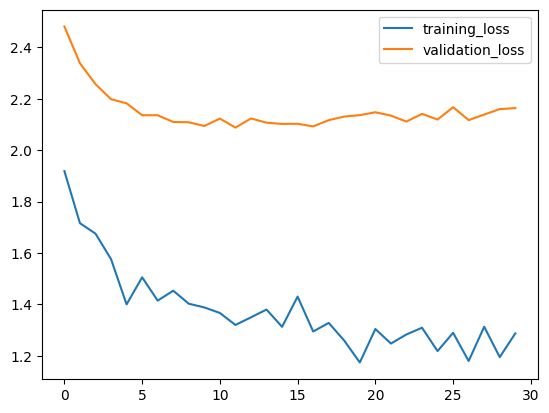

In [24]:
# Validation loss is pretty high, could be an indication of overfitting!
history_train_loss= [0] + [i.item() for i in history_train_loss[1:]]
plt.plot(
    np.arange(len(history_train_loss[1:])),
    history_train_loss[1:],
    label='training_loss'
    )
plt.plot(
    np.arange(len(history_val_loss[1:])),
    history_val_loss[1:],
    label='validation_loss')
plt.legend();

### Load Checkpoint

In [25]:
# set params
batch_size = 1024
n_epochs = 30
window_size = 100

n_layers = 2
dense_dim = 32
embedding_dim = 64
hidden_dim = 128

In [28]:
# Load the dataset object
DATASET_PATH="charlm_dataset_kafka.pt"
dataset_checkpoint = torch.load(DATASET_PATH, weights_only=False)
charlm_dataset2 = dataset_checkpoint['dataset']

In [29]:
# Instantiate Model Object
char_lm2 = CharLM(
            vocab_size=len(charlm_dataset2.vocab),
            hidden_dim=hidden_dim,
            n_layers=n_layers,
            dense_dim=dense_dim,
            embedding_dim=embedding_dim,
    )

criterion2 = torch.nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(
            char_lm2.parameters(),
            lr=1e-2,
    )

# Check GPU if you are coming straight to this section
CUDA = True if torch.cuda.is_available() else False
if CUDA:
  char_lm2.cuda()
  Tensor = torch.cuda.FloatTensor
  LongTensor = torch.cuda.LongTensor
else:
  Tensor = torch.FloatTensor
  LongTensor = torch.LongTensor

In [31]:
# Load Saved Model Checkpoint
# use this if loading on CPU: map_location=torch.device('cpu')
PATH="charlm_kafka.pt"
checkpoint = torch.load(PATH,  weights_only=False)
char_lm2.load_state_dict(checkpoint['model_state_dict'])
optimizer2.load_state_dict(checkpoint['optimizer_state_dict'])
criterion2 = checkpoint['criterion']

# Fix/Freeze weights
char_lm2.eval()

CharLM(
  (embedding): Embedding(89, 64)
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (linear_1): Linear(in_features=128, out_features=32, bias=True)
  (linear_2): Linear(in_features=32, out_features=89, bias=True)
)

### Decoding Strategies

Now we will generate text using different decoding strategies such as:
- Greedy
- Sampling
- Topk Sampling
- Beam Search

In [32]:
prompt_text = "What on earth"
for mode in ["greedy", "sampling", "topk_sampling", "beam_search"]:
  print("-"*25)
  print(f"Generation mode = {mode}")
  print(
    generate_text(
        100,
        char_lm2,
        charlm_dataset2,
        prompt_text=prompt_text,
        mode=mode,
        topk=3,
        temperature=0.3
          )
    )

-------------------------
Generation mode = greedy
What on earth and the chief clerk had to stay on the chief clerk had to stay on the chief clerk had to stay on th
-------------------------
Generation mode = sampling
What on earth was just important on the other, plainting his sister with a wanting on. At no longer morning than 
-------------------------
Generation mode = topk_sampling
What on earth and then the control and something was something that he was so struck to his sister was something 
-------------------------
Generation mode = beam_search
What on earth
of his father would start there was something was so that he was something was so that he was some
